# Libraries importing

In [8]:
import csv
from datetime import date
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from statistics import mean
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import linalg
from sklearn.gaussian_process import kernels,GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import seaborn as sns

In [9]:
!pip install catboost

In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score

# Data loading

In [11]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Load the CSV file
file_path= '/content/drive/My Drive/shap_experiment/data'
df_processed_combined_data_daily = pd.read_csv(file_path+"/processed_combined_imputed_with_neighbors_df_processed_combined_data_daily.csv")

#df_aqi_daily.DateTime = pd.to_datetime(df_aqi_daily.DateTime)
df_processed_combined_data_daily.DateTime = pd.to_datetime(df_processed_combined_data_daily.DateTime)
df_PM10_daily = df_processed_combined_data_daily[['DateTime','Bjelave_PM10']]

Mounted at /content/drive


# Feature Engineering

In [12]:
def add_all_time_features(df, datetime_col='DateTime', target_col='Bjelave_PM10'):
    df_dt=df.copy()
    df_dt['Day'] = df[datetime_col].dt.day.astype(np.float64)               # 1.0, 2.0, ..., 31.0
    df_dt['Month'] = df[datetime_col].dt.month.astype(np.float64)           # 1.0, 2.0, ..., 12.0
    df_dt['Year'] = df[datetime_col].dt.year.astype(np.float64)
    #df['Week_of_Year'] = df[datetime_col].dt.isocalendar().week.astype(np.float64) # 1.0, ..., 52.0
    return df_dt

In [13]:
df_processed_combined_data_daily_dt = add_all_time_features(
    df=df_processed_combined_data_daily
)

In [14]:
df_processed_combined_data_daily_dt.shape

(1826, 15)

In [15]:
df_processed_combined_data_daily.shape

(1826, 12)

# Dataset Splitting

In [16]:
import matplotlib.pyplot as plt
def train_test_split(df, date):
    df = df.copy()
    train_data = df[df['DateTime'] < date].copy()
    test_data = df[df['DateTime'] >= date].copy() # df.DateTime = df.DateTime.dt.strftime('%d/%m/%Y %H:%M')
    return train_data, test_data

def train_test_split_from_to(df, start_date, end_date, slice_date):
    df = df.copy()
    train_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < slice_date)].copy()
    test_data = df[(df['DateTime'] >= slice_date) & (df['DateTime'] <= end_date)].copy()
    return train_data, test_data

def plot_train_test_data(train_data, test_data, date_column, label):
    plt.figure(figsize=(20,10))
    plt.plot(train_data[date_column], train_data[label], color='blue', label='Train Data')
    plt.plot(test_data[date_column], test_data[label], color='orange', label='Test Data')
    plt.xlabel(date_column)
    plt.ylabel(label)
    plt.title(label + ' Train and Test Data')
    plt.legend()
    plt.show()

In [17]:
def plot_boxplot(prediction_data, test_data):
    error = abs(prediction_data - test_data)
    # plot boxplot of error
    plt.figure(figsize=(10,6))
    plt.boxplot(error)
    plt.show()

In [18]:
df_processed_combined_data_daily

,DateTime,wind_speed,wind_direction,precipitation,pressure,temperature,humidity,visibility,cloudiness,Bjelave_PM10,Bjelave_SO2,Bjelave_NO2
0,2018-01-01,1.876859,188.675592,0.012500,940.004167,3.316667,83.500000,17358.823529,7.117647,51.293265,20.956605,34.174856
1,2018-01-02,1.876859,188.675592,0.495833,936.579167,3.541667,93.041667,11216.666667,8.000000,51.293265,27.324796,37.907709
2,2018-01-03,1.876859,188.675592,0.187500,937.400000,3.237500,77.541667,12737.500000,7.112500,61.345475,19.669382,30.834321
3,2018-01-04,1.876859,188.675592,0.000000,935.770833,1.304167,91.500000,11312.500000,6.233333,41.241054,21.401833,31.298637
4,2018-01-05,1.876859,188.675592,0.000000,937.583333,5.183333,74.416667,18941.666667,5.520833,44.815521,20.001500,31.914025
...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-12-27,2.029167,125.375000,0.479167,948.729167,7.879167,79.666667,18579.166667,6.358333,26.714598,22.752038,26.175499
1822,2022-12-28,1.450000,179.125000,0.000000,949.583333,4.591667,82.208333,19416.666667,4.937500,29.372987,23.098171,32.184576
1823,2022-12-29,2.187500,146.166667,0.000000,947.341667,5.354167,81.666667,18812.500000,4.187500,50.187371,25.431842,38.493039
1824,2022-12-30,1.070833,159.541667,0.000000,947.279167,6.429167,79.083333,19416.666667,4.000000,67.841704,27.591008,54.974991


In [19]:
#input window = 7
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=23)
train_data_combined_ws_week, test_data_combined_ws_week = train_test_split(df_processed_combined_data_daily, date) #
train_PM10_daily_ws_week, test_PM10_daily_ws_week = train_test_split(df_PM10_daily, date)

train_data_combined_ws_week_dt, test_data_combined_ws_week_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 15
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=31)
train_data_combined_ws_fifteen, test_data_combined_ws_fifteen = train_test_split(df_processed_combined_data_daily, date) #
train_PM10_daily_ws_fifteen, test_PM10_daily_ws_fifteen = train_test_split(df_PM10_daily, date)

train_data_combined_ws_fifteen_dt, test_data_combined_ws_fifteen_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 30
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=46)
train_data_combined_ws_thirty, test_data_combined_ws_thirty = train_test_split(df_processed_combined_data_daily, date) #
train_PM10_daily_ws_thirty, test_PM10_daily_ws_thirty = train_test_split(df_PM10_daily, date)

train_data_combined_ws_thirty_dt, test_data_combined_ws_thirty_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 60
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=82)
train_data_combined_ws_sixty, test_data_combined_ws_sixty = train_test_split(df_processed_combined_data_daily, date)
train_PM10_daily_ws_sixty, test_PM10_daily_ws_sixty = train_test_split(df_PM10_daily, date)

train_data_combined_ws_sixty_dt, test_data_combined_ws_sixty_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 90
#promijneiti dane kasnije!
#date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=95)
#train_data_combined_ws_ninety, test_data_combined_ws_ninety = train_test_split(df_processed_combined_data_daily, date)
#train_PM10_daily_ws_ninety, test_PM10_daily_ws_ninety = train_test_split(df_PM10_daily, date)

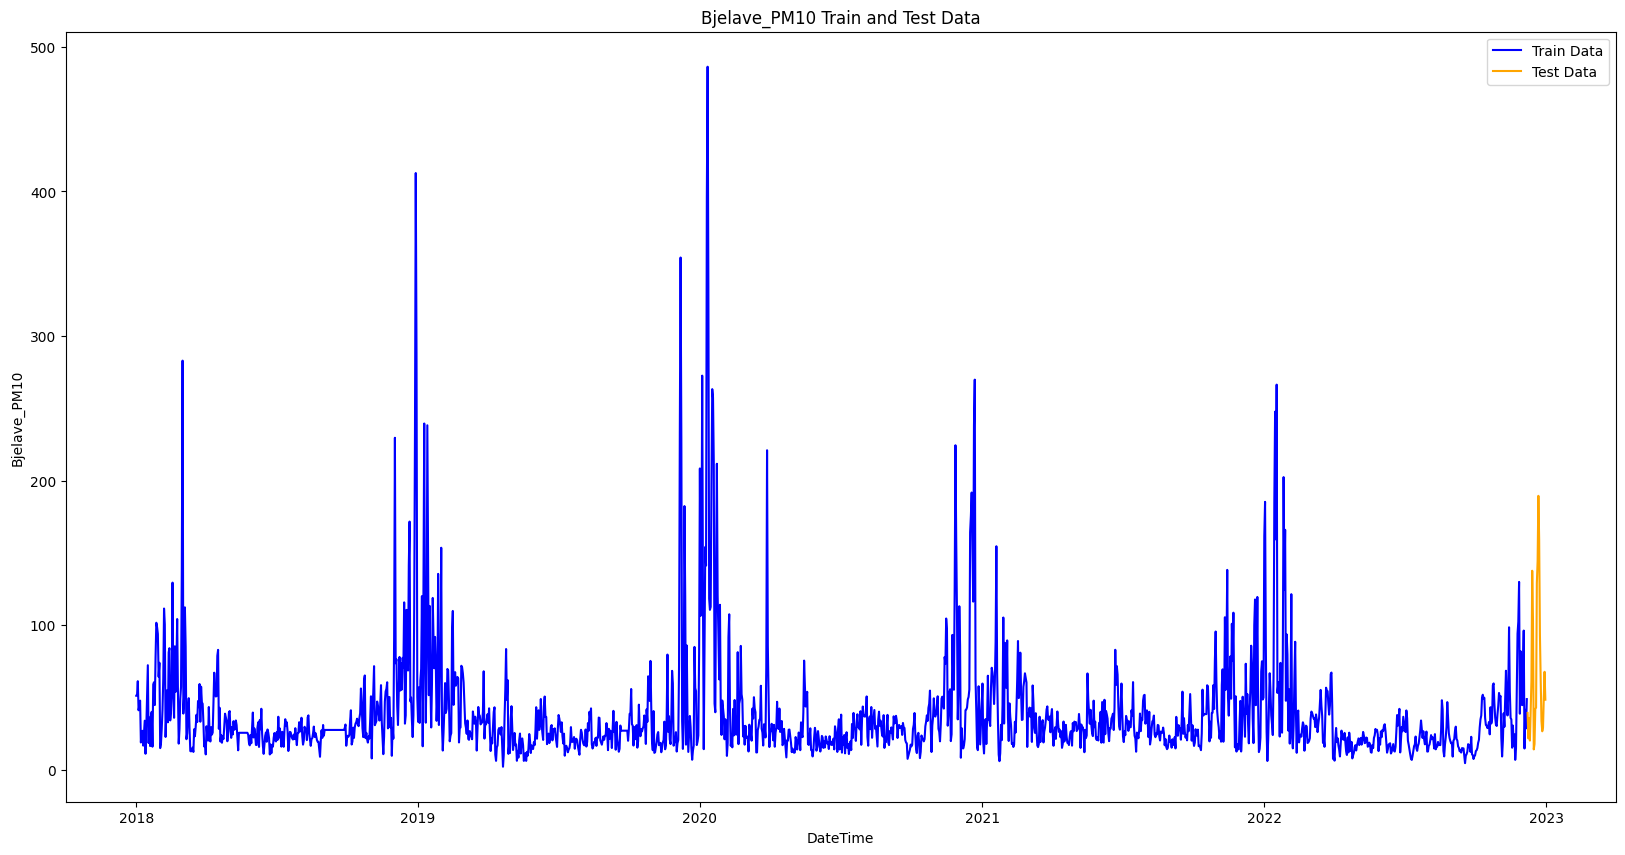

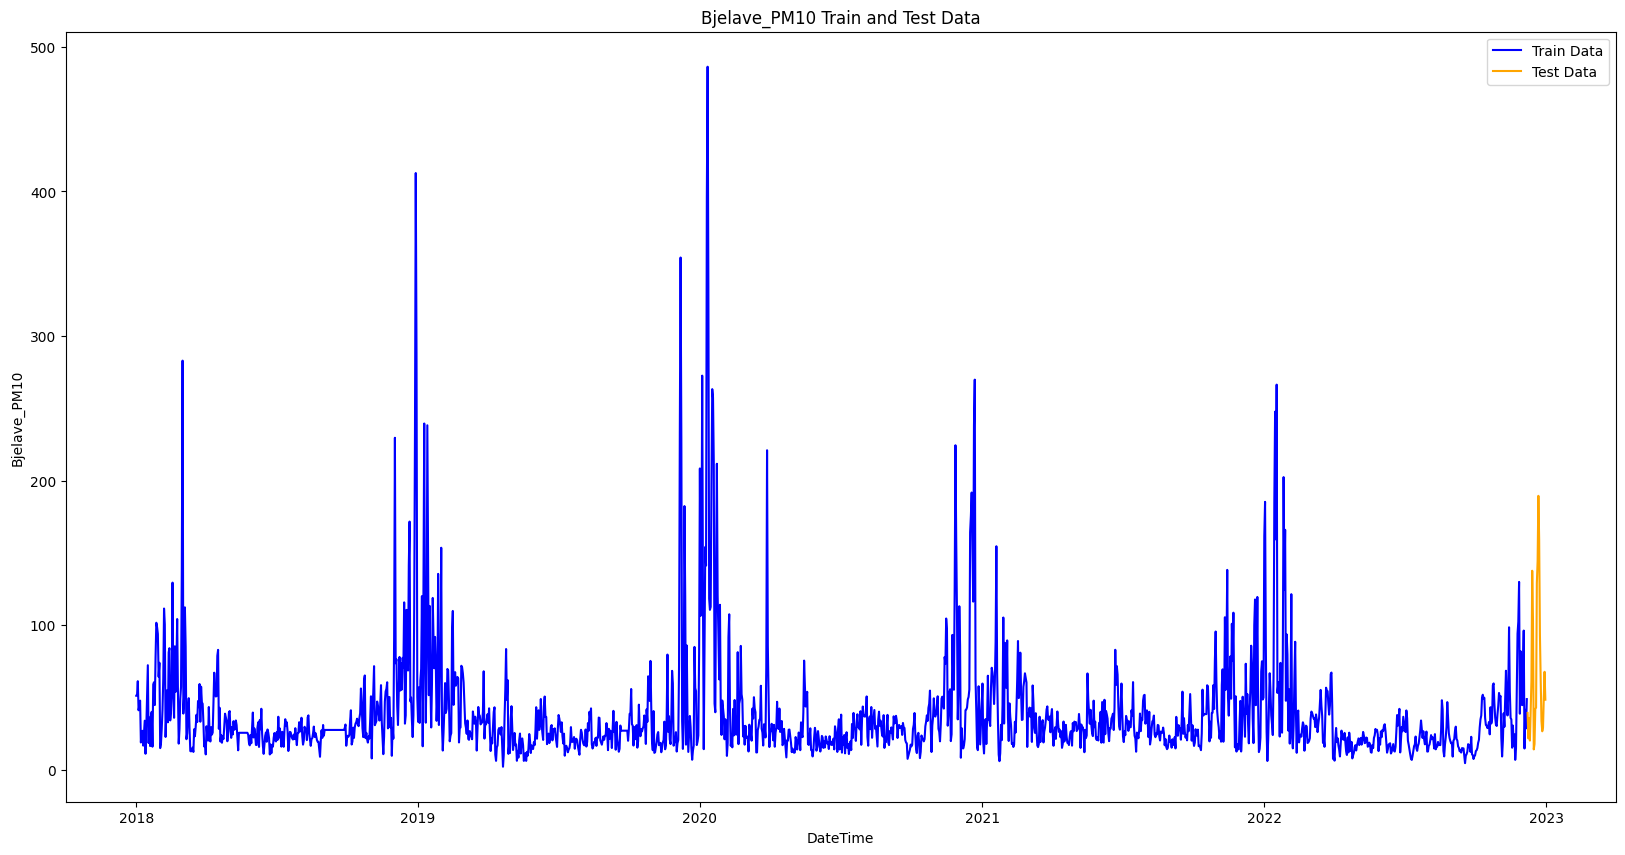

In [20]:
plot_train_test_data(train_data_combined_ws_week, test_data_combined_ws_week, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_PM10_daily_ws_week, test_PM10_daily_ws_week, 'DateTime', 'Bjelave_PM10')

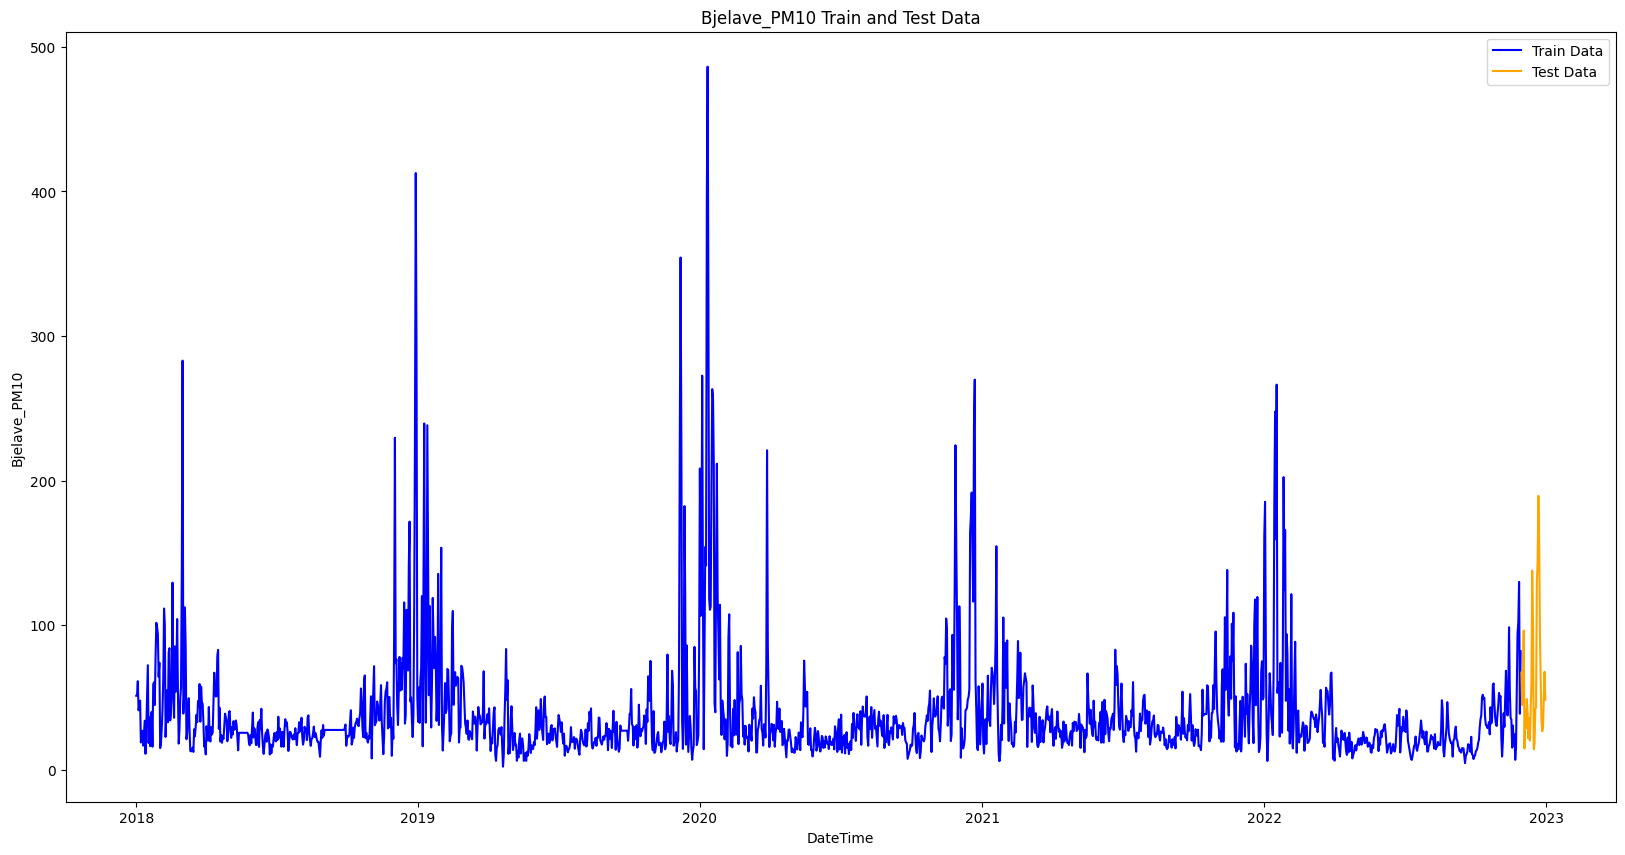

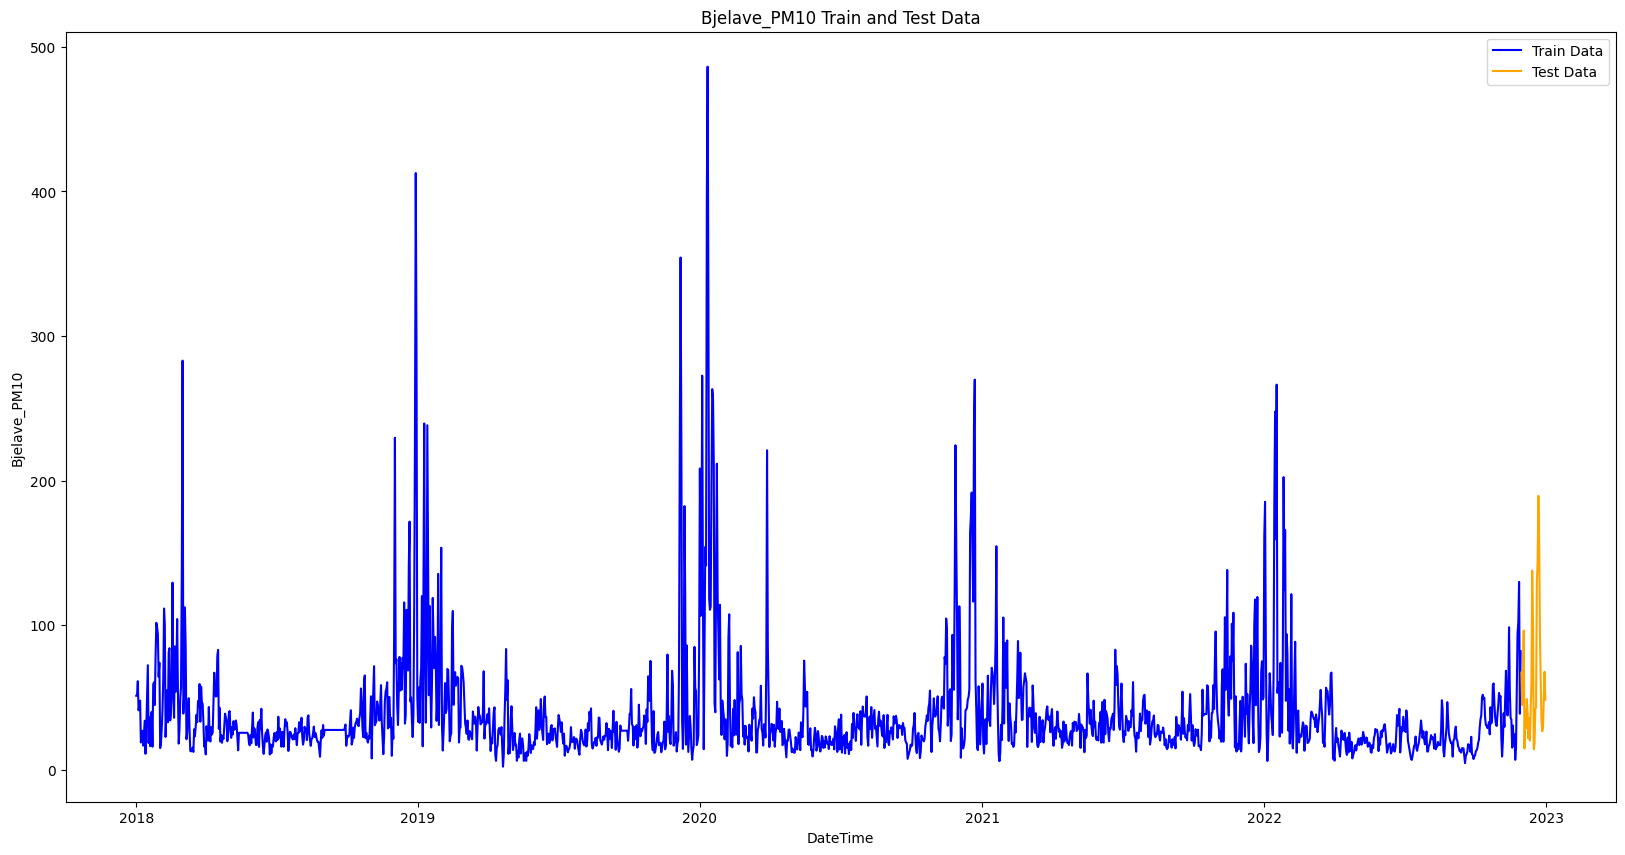

In [21]:
plot_train_test_data(train_data_combined_ws_fifteen, test_data_combined_ws_fifteen, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_PM10_daily_ws_fifteen, test_PM10_daily_ws_fifteen, 'DateTime', 'Bjelave_PM10')

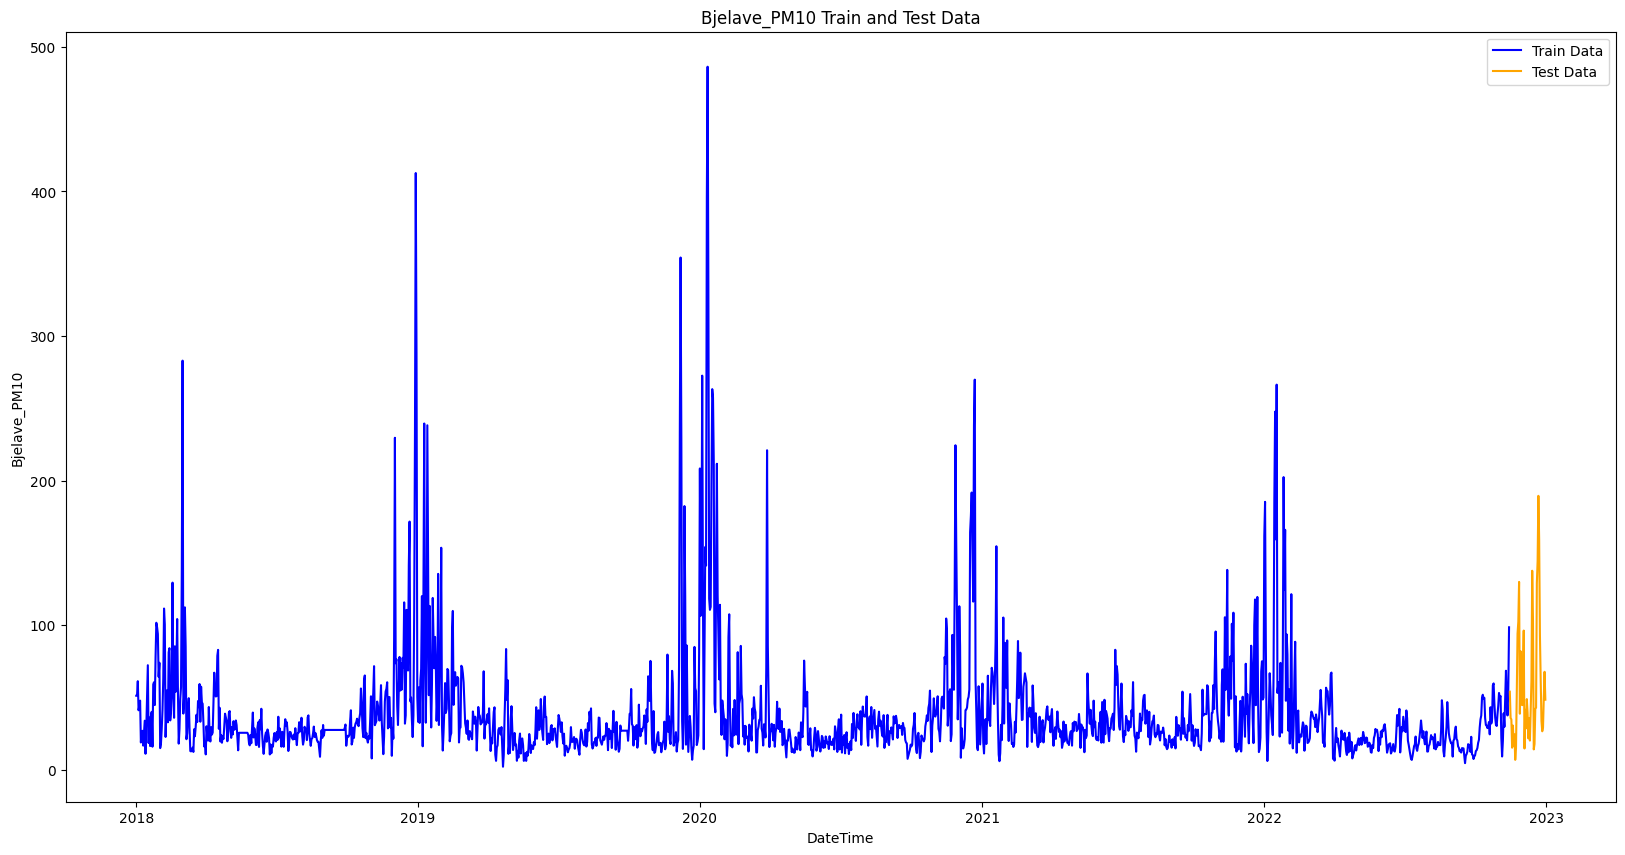

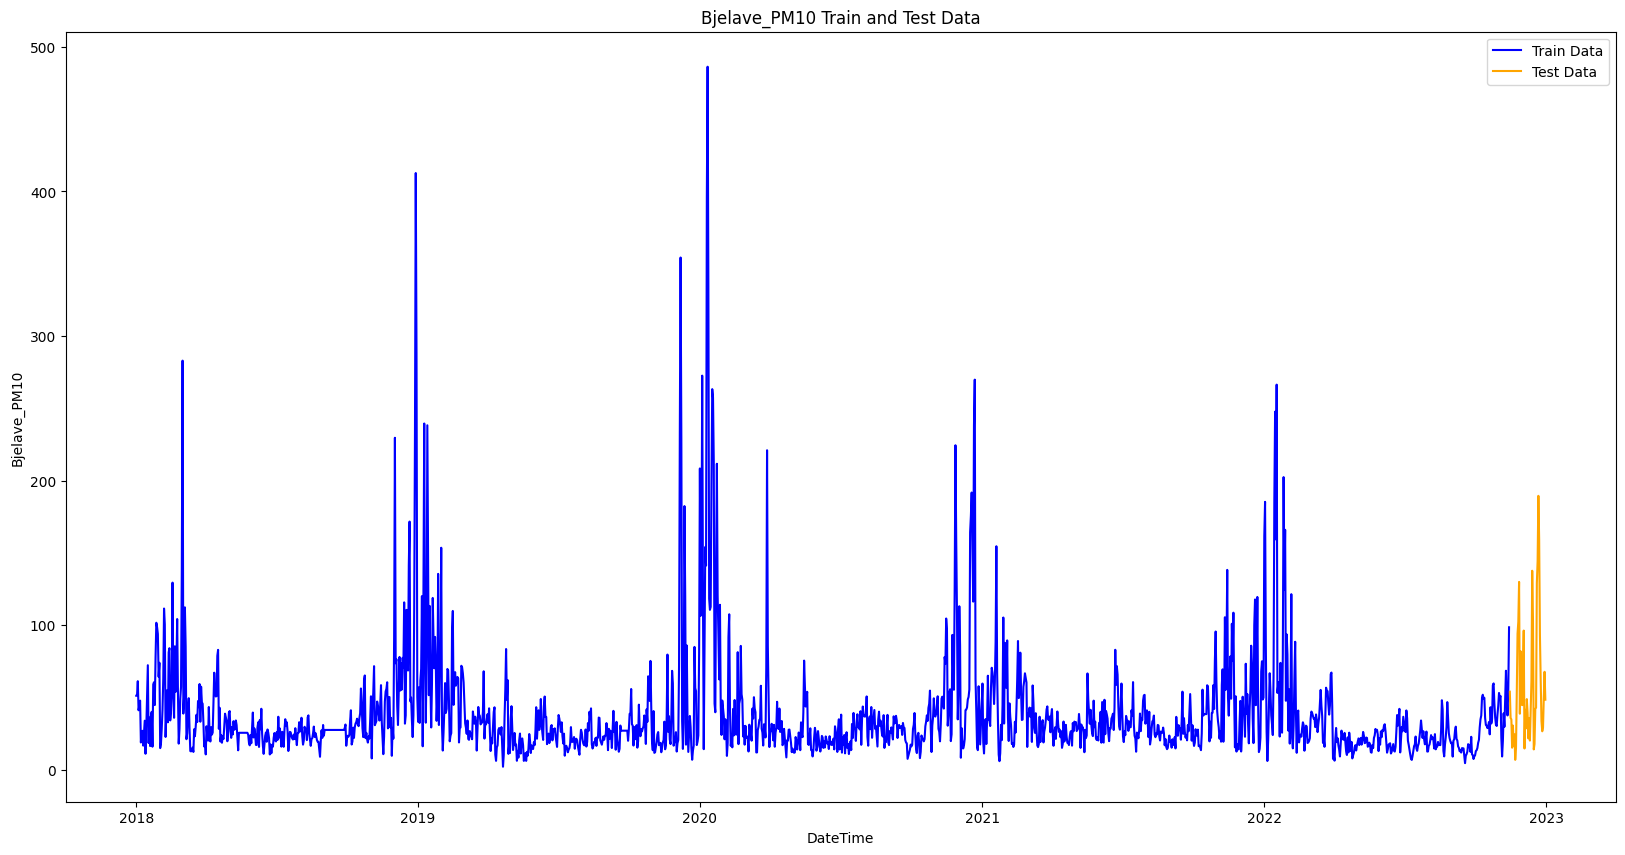

In [22]:
plot_train_test_data(train_data_combined_ws_thirty, test_data_combined_ws_thirty, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_PM10_daily_ws_thirty, test_PM10_daily_ws_thirty, 'DateTime', 'Bjelave_PM10')


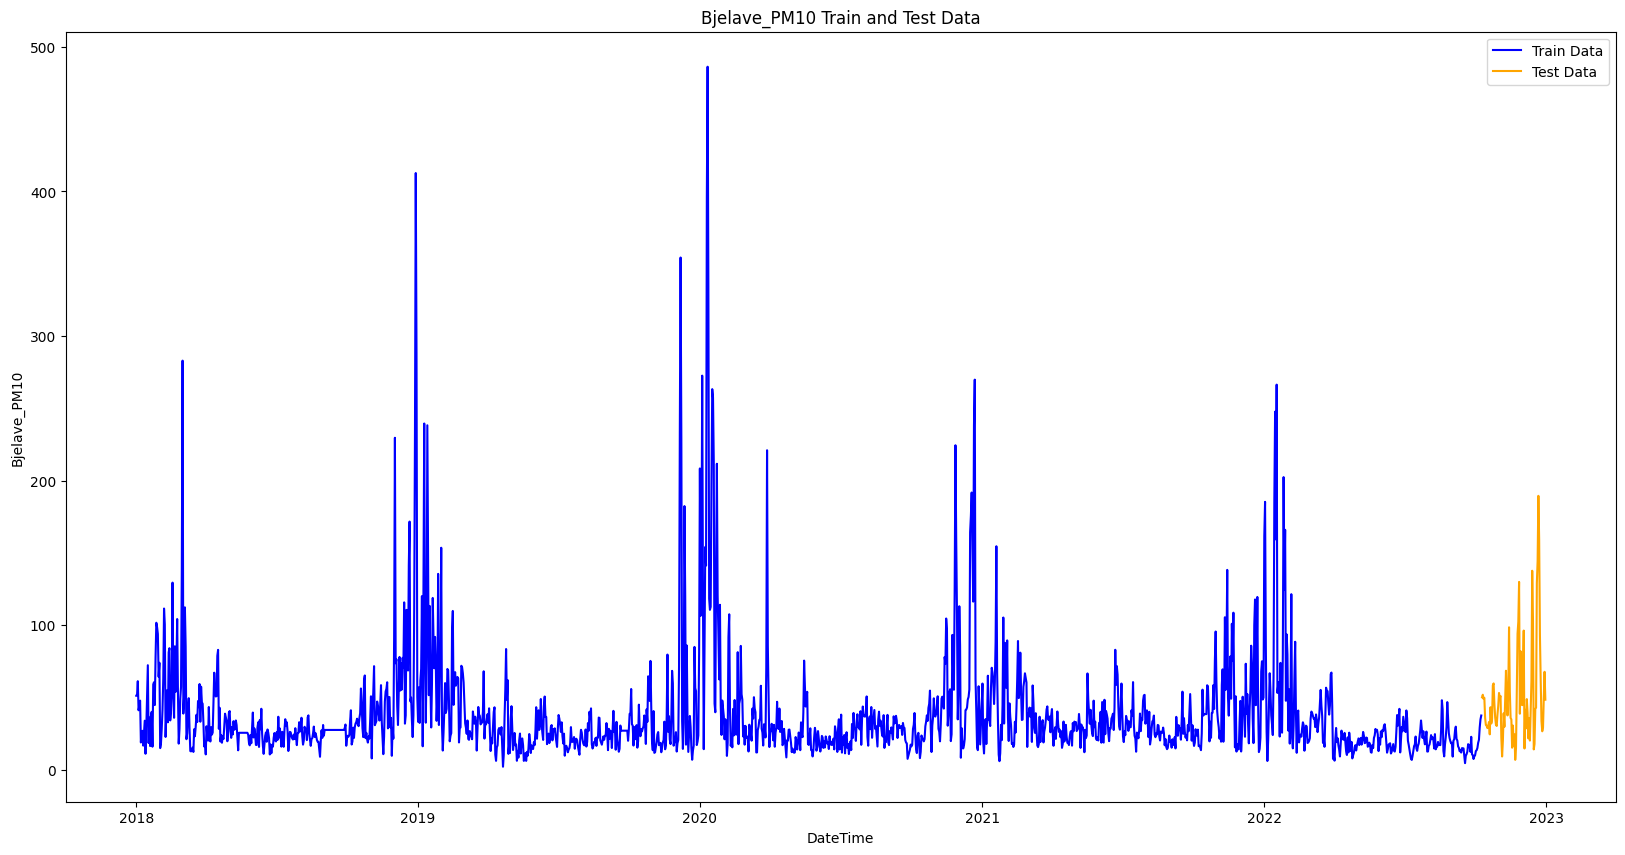

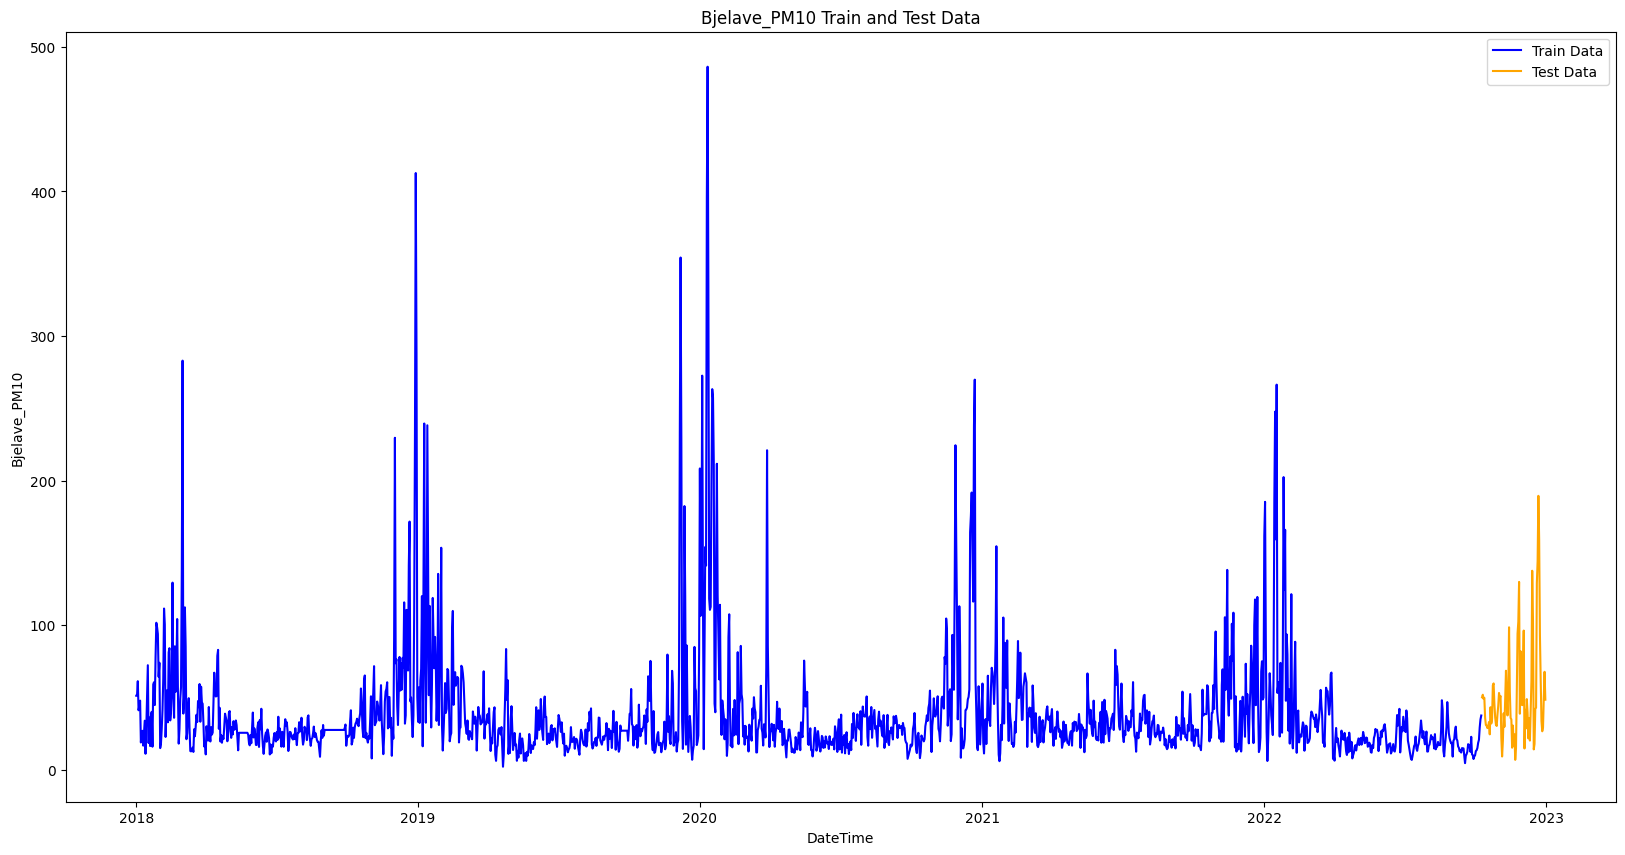

In [23]:
plot_train_test_data(train_data_combined_ws_sixty, test_data_combined_ws_sixty, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_PM10_daily_ws_sixty, test_PM10_daily_ws_sixty, 'DateTime', 'Bjelave_PM10')

# Lag Features

In [25]:
df_processed_combined_data_daily_dt.columns


Index(['DateTime', 'wind_speed', 'wind_direction', 'precipitation', 'pressure',
       'temperature', 'humidity', 'visibility', 'cloudiness', 'Bjelave_PM10',
       'Bjelave_SO2', 'Bjelave_NO2', 'Day', 'Month', 'Year'],
      dtype='object')

In [26]:
target_map = df_processed_combined_data_daily_dt['Bjelave_PM10'].to_dict()

In [27]:
df_processed_combined_data_daily_dt.index

RangeIndex(start=0, stop=1826, step=1)